In [305]:
# Author: Anthony W. Silva
# Date: 11/15/2019

# Disclaimer: I do not own the open source data used in this algorithm

# In this project I will create a machine learning algorithm that can accurately classify handwritten digits
# using data compression techniques such as the Singular Value Decomposition of 
# matrices and the QR decomposition of matrices for reduced computational expense

In [2]:
# Import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
%matplotlib inline

#set seaborn plot style
sns.set_style('whitegrid')

In [3]:
# Load files containing handwritten digit image data

# Training data
Train = scipy.io.loadmat('azip.mat')['azip']

# Testing data
Test = scipy.io.loadmat('testzip.mat')['testzip']

# Correct labels for testing data
Correct = scipy.io.loadmat('dtest.mat')['dtest']

# Labels for training data
Labels = scipy.io.loadmat('dzip.mat')['dzip']

In [4]:
# Print the dimensions of each data matrix
print('Training data dimensions: {}'.format(Train.shape))
print('Testing data dimensions: {}'.format(Test.shape))
print('Labels for testing data dimensions: {}'.format(Correct.shape))
print('Labels for training data dimensions: {}'.format(Labels.shape))

Training data dimensions: (256, 1707)
Testing data dimensions: (256, 2007)
Labels for testing data dimensions: (1, 2007)
Labels for training data dimensions: (1, 1707)


In [5]:
# Columns in training data represent a 16x16 image reshaped into a single column. There are 1707 training images
# Columns in testing data represent a 16x16 image reshaped into a single column. There are 2007 testing images
# Each element in the Correct array is the correct label for each digit in the Test array by index
# Each element in the Labels array is the correct label for each digit in the Train array by index

In [6]:
# Print data types
print(type(Test))
print(type(Train))
print(type(Labels))
print(type(Correct))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
# Sort digit images and labels
SortedLabels = np.sort(Labels)[0] # Sort Labels
ArgSort = np.argsort(Labels)[0] # Sort Labels and tore sorted indexes
SortedTrain = Train[:,ArgSort] # Sort Digits

In [9]:
from itertools import groupby

In [10]:
# Find and print digit set sizes
DigitSetSizes = [len(list(group)) for key, group in groupby(SortedLabels)]
print('DigitSetSizes: {}'.format(DigitSetSizes))


DigitSetSizes: [319, 252, 202, 131, 122, 88, 151, 166, 144, 132]


In [11]:
# Define function to print first appearance of each digit in SortedDigits to verify properly sorted
def PrintFirstDigits(SortedTrain,DigitSetSizes):
    ind = 1
    j = 0
    for i in DigitSetSizes:
        plt.subplot(2,5,ind)
        plt.imshow(np.reshape(np.array(SortedTrain[:,j]),(16,16)),interpolation='nearest')
        ind+=1
        j += i

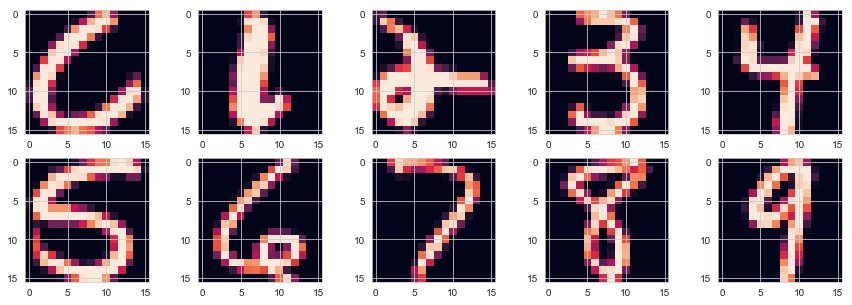

In [12]:
# Instantiate function and print results
plt.figure(figsize=(15,5))
PrintFirstDigits(SortedTrain,DigitSetSizes)

In [13]:
# Partition digits in SortedTrain into separate arrays according to their label
def PartitionDigits(SortedTrain,DigitSetSizes):
    PartitionedDigits = [np.zeros((1,1))]*10
    j = 0
    ind = 0
    for i in DigitSetSizes:    
        PartitionedDigits[ind] = SortedTrain[:,j:i+j]
        j+=i
        ind+=1
    return PartitionedDigits

In [14]:
# Instantiate function
PartitionedDigits = PartitionDigits(SortedTrain,DigitSetSizes)

In [16]:
# Print size of each digit set to verify
for i in range(10):
    print(PartitionedDigits[i].shape[1])

319
252
202
131
122
88
151
166
144
132


In [293]:
# Compress each digit set using a rank 15 SVD approximation and store results into list
Rank15SVD = [np.zeros((1,1))[0]]*10
PlotS = [np.zeros(1)]*10
k=15
for j in range(10):
    U,S,V = np.linalg.svd(PartitionedDigits[j],full_matrices=False)
    U = U[:,0:k] # Grab first 25 dominant singular column vectors for each digit set
    PlotS[j] = S
    Rank15SVD[j] = U # Store dominant singular column vectors

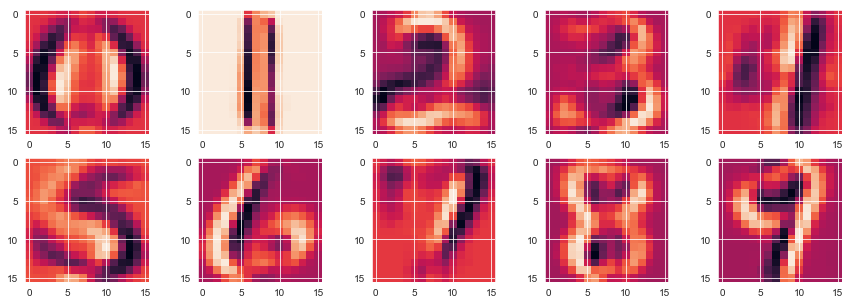

In [294]:
# Print rank 1 SVD approximations of each image (dominant singular column vector of each digit set)
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.reshape(Rank15SVD[i][:,1],(16,16)))

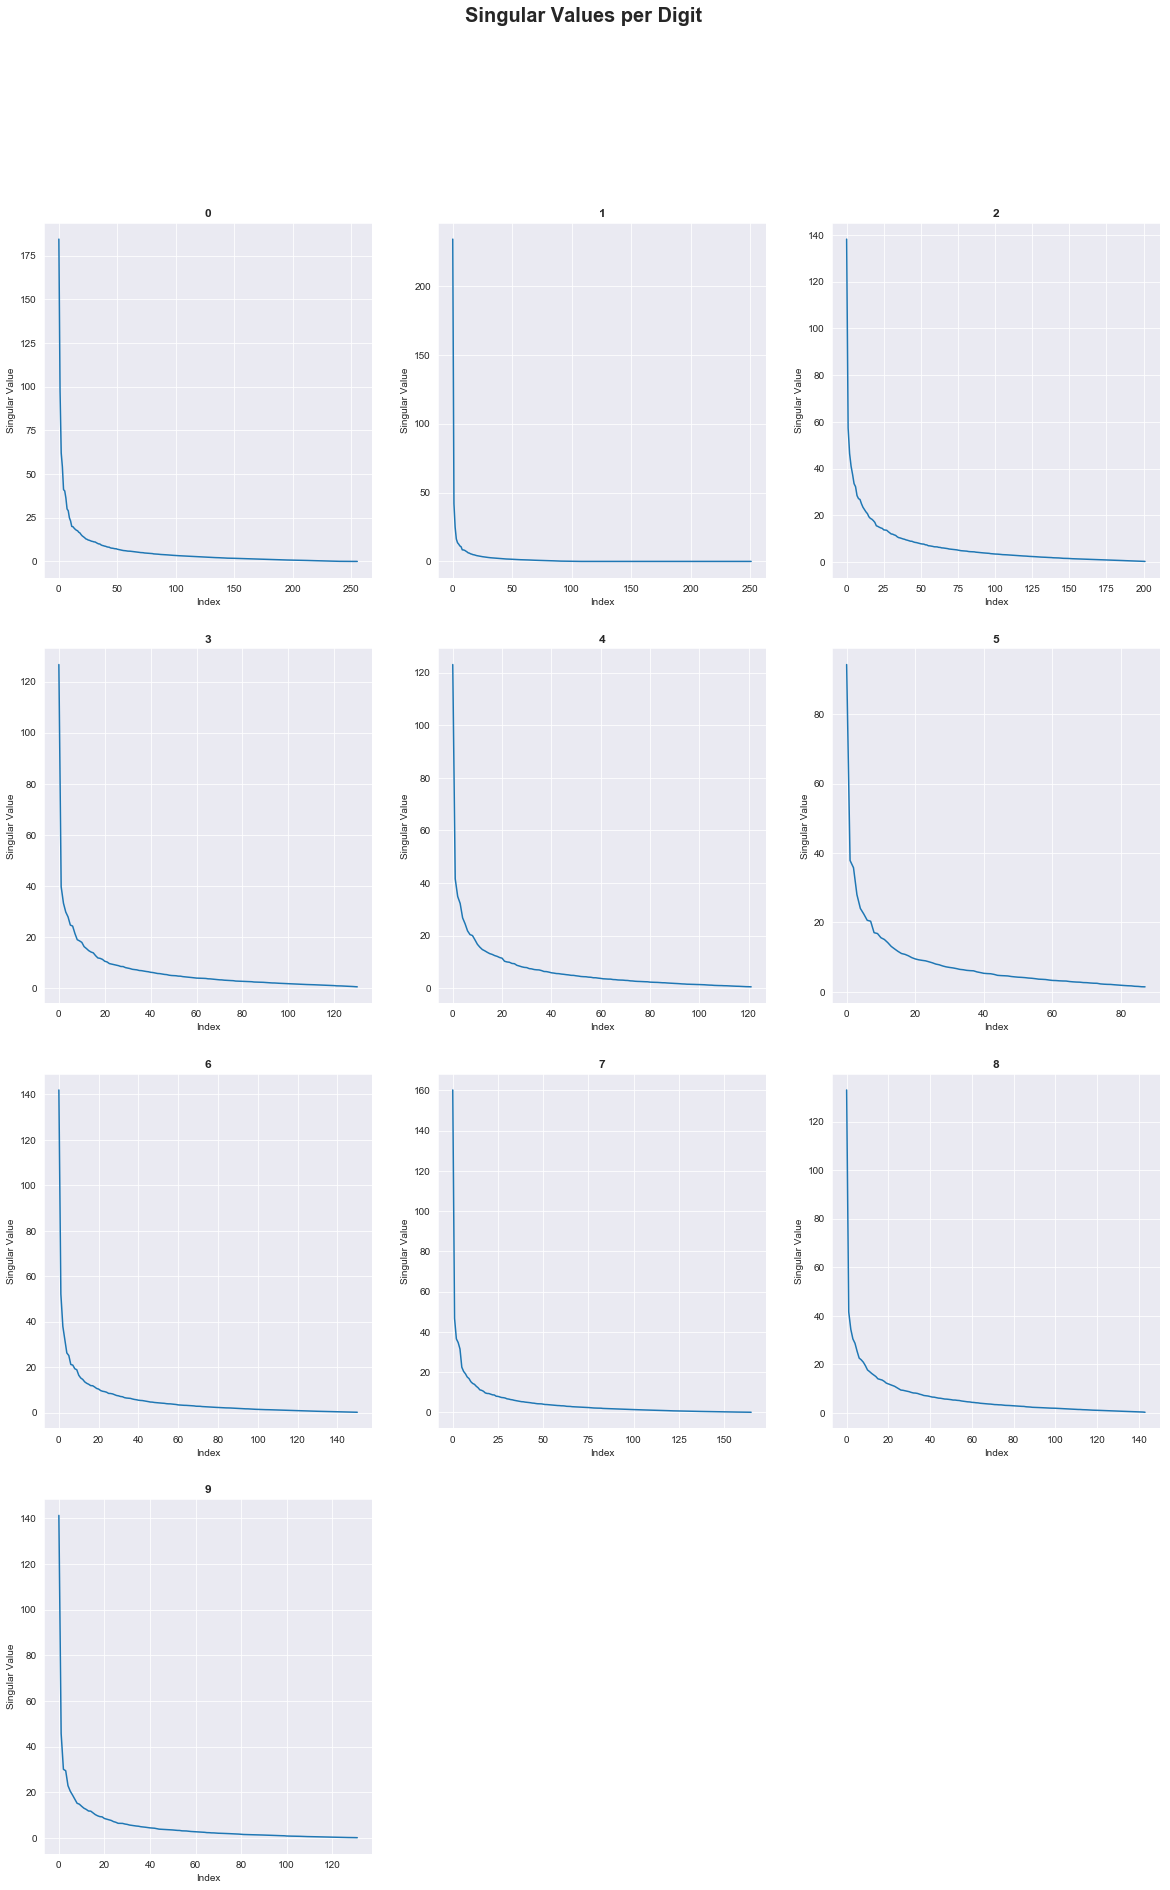

In [295]:
# Plot the Singular Values for each digit set
plt.figure(figsize=(20,30))
sns.set_style('darkgrid')
for i in range(10):
    PlotS[i] = pd.DataFrame(PlotS[i])
    plt.subplot(4,3,i+1)
    plt.plot(PlotS[i])
    plt.title('{}'.format(i),fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.suptitle('Singular Values per Digit',fontweight='bold',fontsize=20)

In [296]:
# Note: Number of singular values for each digit = rank of each digit set

In [297]:
# Calculate reduced QR decomposition of each digit set in Rank15SVD
QR = [[np.zeros((1,1))[0],np.zeros((1,1))[0]]]*10
for i in range(10):
    Q,R = np.linalg.qr(Rank15SVD[i])
    QR[i] = [Q,R]

In [298]:
# Solve system of equations for each digit set in PartitionedDigits and each testing digit in Test
# Use compressed rank 15 SVD approximation and QR decomposition
# of each digit set for increased accuracy and less computational expense
Residuals = [0]*10
Predictions = [0]*len(Correct[0])
for i in range(len(Correct[0])):
    for j in range(10):
        x = np.matmul(np.matmul(np.linalg.inv(QR[j][1]),np.transpose(QR[j][0])),Test[:,i])
        Residuals[j] = np.linalg.norm(np.matmul(Rank15SVD[j],x)-Test[:,i],ord=2)
    Predictions[i] = np.argmin(np.array(Residuals))
    Residuals = [0]*10

In [299]:
# Create confusion matrix of results with rows as predictions and columns as correct labels
from sklearn.metrics import confusion_matrix
ConfusionMatrix = pd.DataFrame(confusion_matrix(Predictions,Correct[0]))
ConfusionMatrix

,0,1,2,3,4,5,6,7,8,9
0,355,0,9,3,1,4,3,0,3,0
1,0,260,1,0,1,1,1,1,0,3
2,2,0,179,3,0,2,0,1,1,0
3,0,0,3,148,0,9,0,0,4,0
4,1,3,2,1,186,0,2,3,0,3
5,0,0,1,8,1,140,1,0,2,0
6,0,1,0,0,3,0,162,0,0,0
7,0,0,1,1,3,0,0,141,1,4
8,0,0,2,2,0,1,1,0,153,2
9,1,0,0,0,5,3,0,1,2,165


In [300]:
# Accuracy results
Accuracy = [0]*10
for i in range(10):
    Accuracy[i] = ConfusionMatrix[i][i]/ConfusionMatrix[:][i].sum()
pd.DataFrame(Accuracy,[0,1,2,3,4,5,6,7,8,9],columns=['Accuracy'])

,Accuracy
0,0.988858
1,0.984848
2,0.904040
3,0.891566
4,0.930000
5,0.875000
6,0.952941
7,0.959184
8,0.921687
9,0.932203


In [301]:
# Interactive plots
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [306]:
# Create barplot of accuracy data
AccuracyDataFrame = pd.DataFrame(Accuracy)
AccuracyDataFrame.iplot(kind='bar')

In [303]:
# Calculate overall model accuracy
TotalAccuracy = np.sum(np.diag(np.array(ConfusionMatrix)))/len(Correct[0])
print('Overall model accuracy: {}%'.format(round(TotalAccuracy*100),5))

Overall model accuracy: 94.0%


In [304]:
# Conclusion: My algorithm had a 94% success rate when classifying Test handwritten digits.
# Overall results were very good with some exceptions for digits 2,3, and 5 which clearly
# had some of the lowest accuracy. May need to try an alternate method for 
# these digits. 